This notebook plots variable importance held per genome, as well as taxonomy information. 
The first plot shows the minimum and maximum variable importance that could be held by each genome (greedy gather vs. all possible hashes per genome). 
The key for the ranks occurs in the dataframe below the plot.
The plot went through several iterations, scroll down to the bottom to see the final metacoder plot.
The ggtree plots look like it didn't render properly in the notebook; run the code in RStudio where the graphic visualizer auto scales better.

In [1]:
setwd("..")

In [ ]:
# adjust plot size rendered inline
options(repr.plot.width = 4, repr.plot.height = 2.4, repr.plot.res = 300)

In [57]:
library(dplyr)
library(readr)
library(tidyr)
library(purrr)
library(rjson)
library(ggplot2)
library(ggpubr)
library(ggtree)
library(aplot)
library(metacoder)

### read in gather results to get shared assemblies

+ read in gtdb derep + genbank protozoa, fungi, viral gather results.
+ subset to assemblies identified in all models. 
+ summarize to species level to group queries of the same species together.
+ Then, summarize the variable importance held by each genome and plot.

In [4]:
# read in gather results and subset to accessions shared between all models
# gather_files <- snakemake@input[["gather"]]
# gather_files <- unlist(gather_files, use.names=FALSE)
gather_files <- Sys.glob("outputs/gather/*gtdb*seed*csv")
gather_results <- gather_files %>%
  set_names() %>%
  map_dfr(read_csv, show_col_types = F, .id = "source")  %>%
  dplyr::mutate(source = gsub("outputs/gather/", "", source),
         source = gsub("vita_vars_gtdb_", "", source),
         source = gsub(".csv", "", source)) %>%
  separate(col = name, into = c("accession"), remove = F, sep = " ", extra = "drop") %>%
  separate(col = source, into = c("study", "seed"), remove = T, sep = "_", extra = "drop") %>%
  mutate(accession = gsub("\\..*", "", accession))

In [5]:
shared_assemblies <- gather_results %>%
  group_by(name) %>%
  tally() %>%
  filter(n == 36)

In [6]:
gather_results_shared_assemblies <- gather_results %>%
  filter(name %in% shared_assemblies$name)

### filter based on variable importance

In [7]:
# shared assemblies are present in all models; read in smallest set
# reads in signatures of matches and generates a hash:assembly dataframe
sig_json <- fromJSON(file = "outputs/gather/SRP057027_vita_vars_gtdb_seed6.matches")
# sig_json <- fromJSON(file = unlist(snakemake@input[["gather_matches"]], use.names = F)[1])
hash_to_assembly <- lapply(sig_json, data.frame, stringsAsFactors = FALSE)
hash_to_assembly <- bind_rows(hash_to_assembly)

In [8]:
hash_to_assembly_shared_assemblies <- hash_to_assembly %>%
  filter(name %in% shared_assemblies$name) %>%
  select(name, signatures.mins)

### read in variable importance from the models

In [9]:
read_varimp <- function(path_optimal_rf){
  study <- gsub("outputs\\/optimal_rf_seed\\/", "", path_optimal_rf)
  study <- gsub("_optimal_rf", "", study)
  study <- gsub(".RDS", "", study)
  optimal_rf <- readRDS(path_optimal_rf)
  varimp <- data.frame(hash = names(optimal_rf$variable.importance), 
                       importance = optimal_rf$variable.importance,
                       study = study)
  varimp <- separate(varimp, col = study, into = c("study", "seed"), sep = "_")
  rownames(varimp) <- seq(1:nrow(varimp))
  varimp$hash <- as.numeric(as.character(varimp$hash))
  # add a column where varimp is normalized by the total var imp
  # e.g., divide by the sum of all variable importances
  # this will make all variable importance measures sum to 1
  varimp$model_norm_imp <- varimp$importance / sum(varimp$importance)
  return(varimp)
}

In [10]:
varimp <- Sys.glob("outputs/optimal_rf_seed/*RDS") %>%
#varimp <- unlist(snakemake@input[["varimp"]], use.names = F) %>%
  map_dfr(read_varimp) %>%
  mutate(all_model_norm_imp = model_norm_imp / 36)

In [11]:
# join with assembly information 
varimp <- left_join(varimp, hash_to_assembly_shared_assemblies, by = c("hash" ="signatures.mins"))
varimp <- varimp %>%
  mutate(accession = gsub("\\..*", "", name))

### assign each hash once per model

In [12]:
studies <- unique(gather_results_shared_assemblies$study)
seeds <- unique(gather_results_shared_assemblies$seed) 

In [13]:
# use gather results to iteratively assign hashes and their importance to genomes
# initialize  varimp_assigned
varimp_assigned <- data.frame()

In [ ]:
# loop over each model
for(studyf in studies){
  for(seedf in seeds){
    # filter to the gather pangenome results for this model
    csv_path <- paste0("outputs/gather/", studyf, "_vita_vars_gtdb_", seedf, ".csv")
    gather_results_model <- read_csv(csv_path)
    
    # for each row in the gather results, grab all the hashes that are "owned"
    # by that genome. Once the hash is anchored to one genome, remove it from 
    # consideration for the rest.
    
    # initialize varimp_minus as only varimp for model that's being looped over
    varimp_minus <- varimp %>%
      filter(study %in% studyf) %>%
      filter(seed %in% seedf)
    
    for(i in 1:nrow(gather_results_model)){
      match <- gather_results_model[i, ]$name
      # get all of the (leftover) possible matches for a genome
      varimp_match <- varimp_minus %>%
        filter(name %in% match)
      # save the matches for the model
      varimp_assigned <- bind_rows(varimp_match, varimp_assigned)
      # remove the hashes that were anchored to a genome
      varimp_minus <- varimp_minus %>%
        filter(!hash %in% varimp_match$hash)
    }
  }
}

In [15]:
# CAN SKIP FOR LOOPS AND PICK UP HERE, READING IN FILE
# write_tsv(varimp_assigned, "varimp_assigned_gather_gtdb.tsv")
varimp_assigned <- read_tsv("varimp_assigned_gather_gtdb.tsv", show_col_types = F)

### plot with gather-anchoring of hashes and importance

In [16]:
varimp_assigned <- varimp_assigned %>%
  mutate(model = paste(study, seed, sep = "_"))

In [17]:
varimp_summarized_to_genome_by_model <- varimp_assigned %>%
  group_by(study, seed, model, name) %>%
  summarize(all_model_norm_imp_by_genome_and_model = sum(all_model_norm_imp)) %>%
  ungroup()

`summarise()` has grouped output by 'study', 'seed', 'model'. You can override using the `.groups` argument.


In [18]:
varimp_summarized_to_genome <- varimp_assigned %>%
  group_by(name) %>%
  summarize(all_model_norm_imp_by_genome =  sum(all_model_norm_imp)) %>%
  arrange(desc(all_model_norm_imp_by_genome)) %>%
  filter(!grepl("Cyclospora cayetanensis", name)) %>%
  filter(!is.na(name)) %>%
  mutate(rank = 1:360)

In [19]:
rank54 <- varimp_summarized_to_genome %>%
  filter(rank < 55)

In [20]:
# how much variable importance could be held by the top 54 genomes?
tmp <- varimp_assigned %>%
  filter(name %in% rank54$name)
sum(tmp$all_model_norm_imp)

[1] 0.4978479

In [21]:
varimp_summarized <- varimp_summarized_to_genome_by_model %>%
  left_join(varimp_summarized_to_genome) %>%
  filter(!grepl("Cyclospora cayetanensis", name)) %>% # filter; genome is ridiculously contaminated
  filter(!is.na(name)) %>%
  arrange(rank)

Joining, by = "name"


In [22]:
per_model_varimp_plt <- ggplot(varimp_summarized %>%
         filter(rank <= 54), 
       aes(y = model, x = reorder(as.factor(rank), rank),
           fill = all_model_norm_imp_by_genome_and_model)) +
  geom_tile() +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 7),
        axis.text.x = element_text(size = 7, angle = 45),
        legend.position = "right") +
  labs(x = "rank", fill = "scaled\nvariable\nimportance") +
  scale_fill_viridis_c() 

In [23]:
cumulative_varimp_min_plt <- ggplot(varimp_summarized  %>%
         filter(rank <= 54) %>%
         select(name, rank, all_model_norm_imp_by_genome) %>%
         distinct(), 
       aes(x = reorder(as.factor(rank), rank), y = all_model_norm_imp_by_genome)) +
  geom_col() +
  theme_classic() +
  theme(axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.text.y = element_text(size = 7))+
  labs(x = "rank", y = "minimum")

### plot with out gather-anchoring of hashes and importance

In [24]:
varimp <- varimp %>%
  mutate(model = paste(study, seed, sep = "_"))

In [25]:
varimp_summarized_to_genome_by_model <- varimp %>%
  group_by(study, seed, model, name) %>%
  summarize(all_model_norm_imp_by_genome_and_model = sum(all_model_norm_imp)) %>%
  ungroup()

`summarise()` has grouped output by 'study', 'seed', 'model'. You can override using the `.groups` argument.


In [26]:
varimp_summarized_to_genome <- varimp %>%
  group_by(name) %>%
  summarize(all_model_norm_imp_by_genome =  sum(all_model_norm_imp)) %>%
  arrange(desc(all_model_norm_imp_by_genome)) %>%
  filter(!grepl("Cyclospora cayetanensis", name)) %>%
  filter(!is.na(name)) %>%
  mutate(rank = 1:360)

In [27]:
varimp_summarized <- varimp_summarized_to_genome_by_model %>%
  left_join(varimp_summarized_to_genome) %>%
  filter(!grepl("Cyclospora cayetanensis", name)) %>%
  filter(!is.na(name)) %>%
  arrange(rank)

Joining, by = "name"


In [28]:
# per_model_varimp_plt <- ggplot(varimp_summarized %>%
#                                  filter(all_model_norm_imp_by_genome >= 0.01), 
#                                aes(x = model, y = reorder(as.factor(rank), -rank),
#                                    fill = all_model_norm_imp_by_genome_and_model)) +
#   geom_tile() +
#   theme_minimal() +
#   theme(axis.text.x = element_text(angle = 90, size = 7, vjust = .5),
#         axis.text.y = element_text(size = 7),
#         legend.position = "right") +
#   labs(y = "rank", fill = "scaled\nvariable\nimportance") +
#   #scale_y_discrete(limits=rev) 
#   scale_fill_viridis_c() 

In [29]:
cumulative_varimp_max_plt <- ggplot(varimp_summarized  %>%
                                  filter(all_model_norm_imp_by_genome >= 0.01) %>%
                                  select(name, rank, all_model_norm_imp_by_genome) %>%
                                  distinct(), 
                                aes(x = reorder(as.factor(rank), rank), y = all_model_norm_imp_by_genome)) +
  geom_col() +
  theme_classic() +
  theme(axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.text.y = element_text(size = 7))+
  labs(x = "rank", y = "maximum")

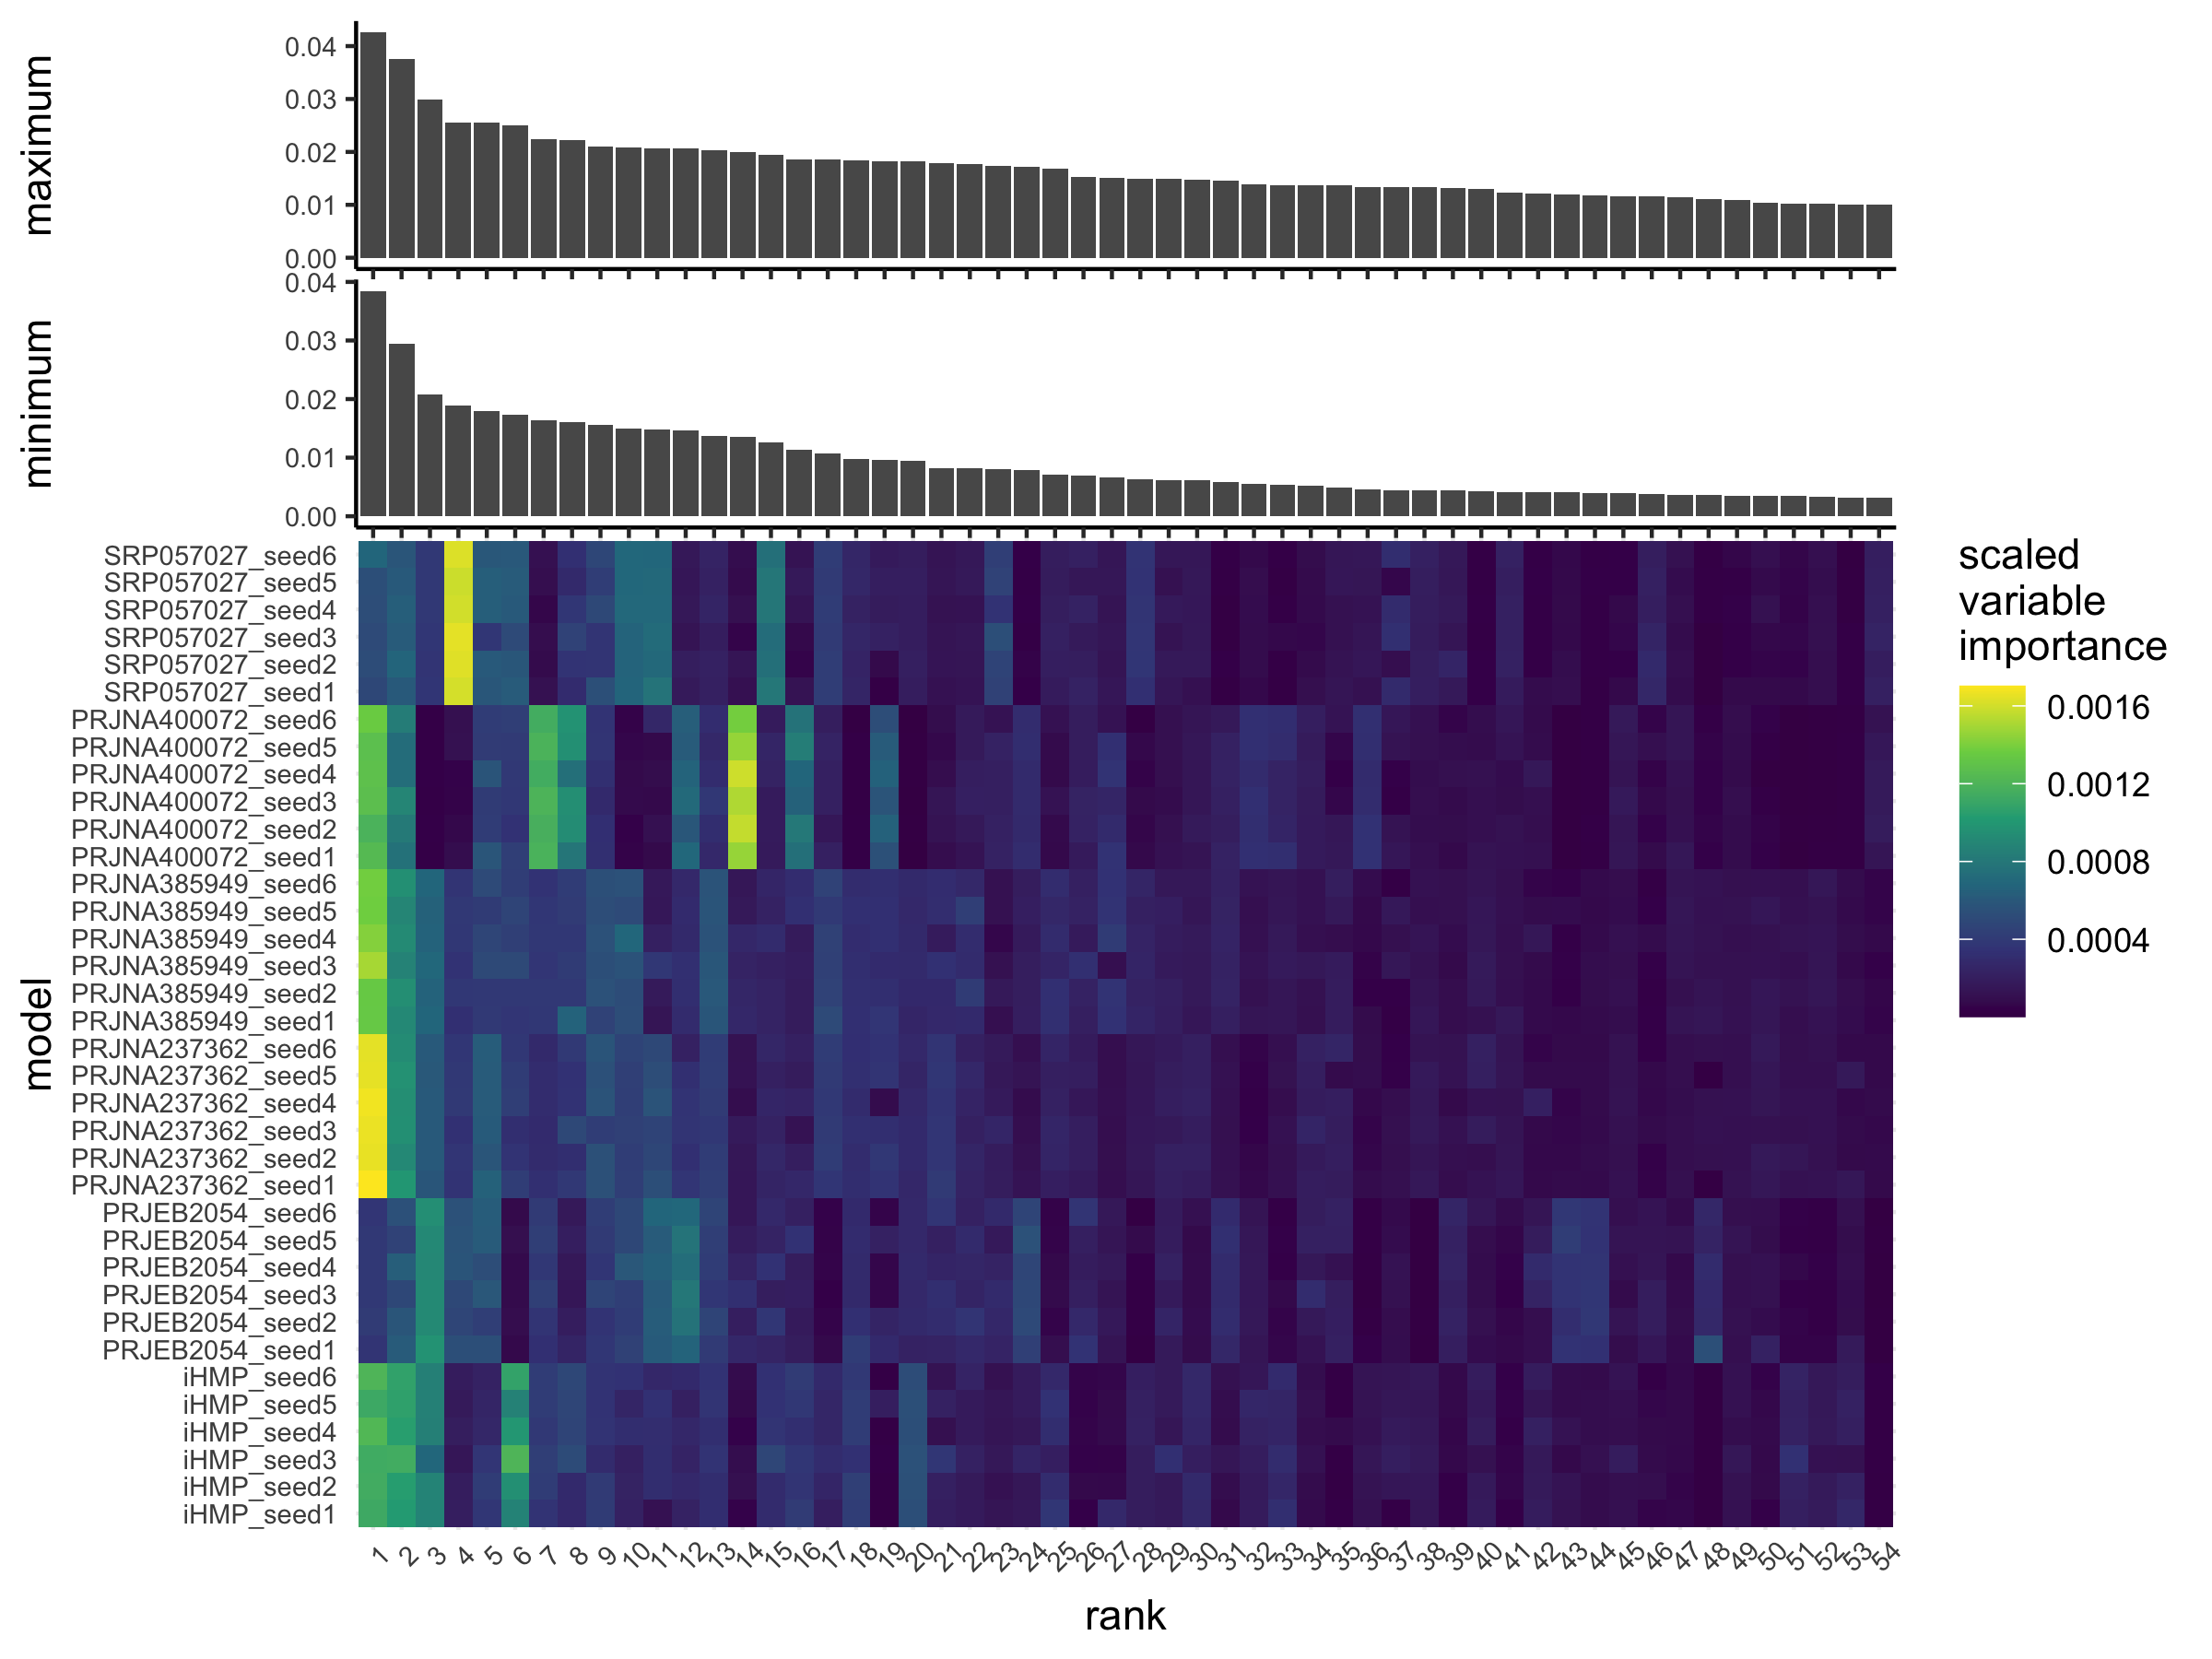

In [34]:
# adjust plot size rendered inline
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)
#pdf("figures/cumulative_variable_importance_top54.pdf", height = 6, width =6)
cumulative_varimp_min_plt %>%
  insert_bottom(per_model_varimp_plt, height = 4) %>%
  insert_top(cumulative_varimp_max_plt)
#dev.off()

In [81]:
varimp_summarized %>% 
  select(name, rank, all_model_norm_imp_by_genome) %>% 
  distinct() %>%
  filter(rank < 55)

name,rank,all_model_norm_imp_by_genome
<chr>,<int>,<dbl>
"GCF_003584705.1 Lachnospiraceae bacterium GAM79 strain=GAM79, ASM358470v1",1,0.04260548
"GCA_014337175.1 Lachnospiraceae bacterium sunii NSJ-8 strain=NSJ-8, ASM1433717v1",2,0.03753086
"GCF_000508885.1 Clostridiales bacterium VE202-03 strain=VE202-03, ASM50888v1",3,0.02997283
"GCF_002549755.1 Faecalibacterium prausnitzii strain=CNCM I 4540, ASM254975v1",4,0.02561551
"GCF_003293635.1 Faecalibacterium prausnitzii strain=942/30-2, ASM329363v1",5,0.02557285
"GCF_000239295.1 Flavonifractor plautii ATCC 29863 strain=ATCC 29863, ASM23929v1",6,0.02504348
"GCF_003324185.1 Faecalibacterium prausnitzii strain=ATCC 27768, ASM332418v1",7,0.02239243
"GCF_000765235.1 Oscillibacter sp. ER4 strain=ER4, ASM76523v1",8,0.02219453
"GCF_002234575.2 Enterocloster bolteae strain=ATCC BAA-613, ASM223457v2",9,0.02093700


### plot companion tree

In [46]:
# get genomes of interest, taxonomy, and rank
genomes <- varimp_summarized_to_genome %>%
  select(name, rank) %>%
  distinct() %>%
  filter(!grepl("Cyclospora cayetanensis", name)) %>%
  filter(!is.na(name)) 

In [47]:
genomes <- genomes %>%
  separate(name, into = c("accession"), sep = " ", extra = "drop", remove = T)

In [48]:
lineagefile <- "inputs/gtdb-rs202.taxonomy.v2.csv"
url <- "https://osf.io/p6z3w/download"
if (!file.exists(lineagefile)) {
  download.file(url, lineagefile, method="auto") 
}

In [50]:
# get full lineages from genomes of interest
gtdb_lineages <- read_csv(lineagefile, show_col_types = F)
gtdb_lineages <- gtdb_lineages %>%
  filter(ident %in% genomes$accession) %>%
  left_join(genomes, by = c("ident" = "accession")) %>%
  mutate(species2 = gsub("s__", "", species)) %>%
  mutate(phylum = gsub("p__", "", phylum)) %>%
  mutate(varimp_greater_than_1pct = ifelse(rank > 54, "no", "yes"))

In [51]:
# Build tree
destfile <- "inputs/gtdb_trees/bac120_r202.tree"
url <- "https://data.gtdb.ecogenomic.org/releases/release202/202.0/bac120_r202.tree"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}

In [52]:
gtdb_tree <- phytools::read.newick(destfile)
# drop tips from GTDB. This tree contains all GTDB species.
drop_tips <- gtdb_tree$tip.label[!str_detect(gtdb_tree$tip.label, paste(genomes$accession, collapse="|"))]
gtdb_tree <- ape::drop.tip(gtdb_tree, drop_tips)
# edit tip labels to remove GC/RS
gtdb_tree$tip.label <- gsub("RS_", "", gtdb_tree$tip.label) 
gtdb_tree$tip.label <- gsub("GB_", "", gtdb_tree$tip.label) 

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

ERROR: Error in str_detect(gtdb_tree$tip.label, paste(genomes$accession, collapse = "|")): could not find function "str_detect"


In [53]:
# order lineages by tip labels
gtdb_lineages <- gtdb_lineages[match(gtdb_tree$tip.label, gtdb_lineages$ident), ]

In [54]:
# create tree, and add info about tips
p_bac <- ggtree(gtdb_tree, layout = "circular", branch.length = 'none') %<+% gtdb_lineages

Warning message:
“Removed 45555 rows containing missing values (geom_point_g_gtree).”


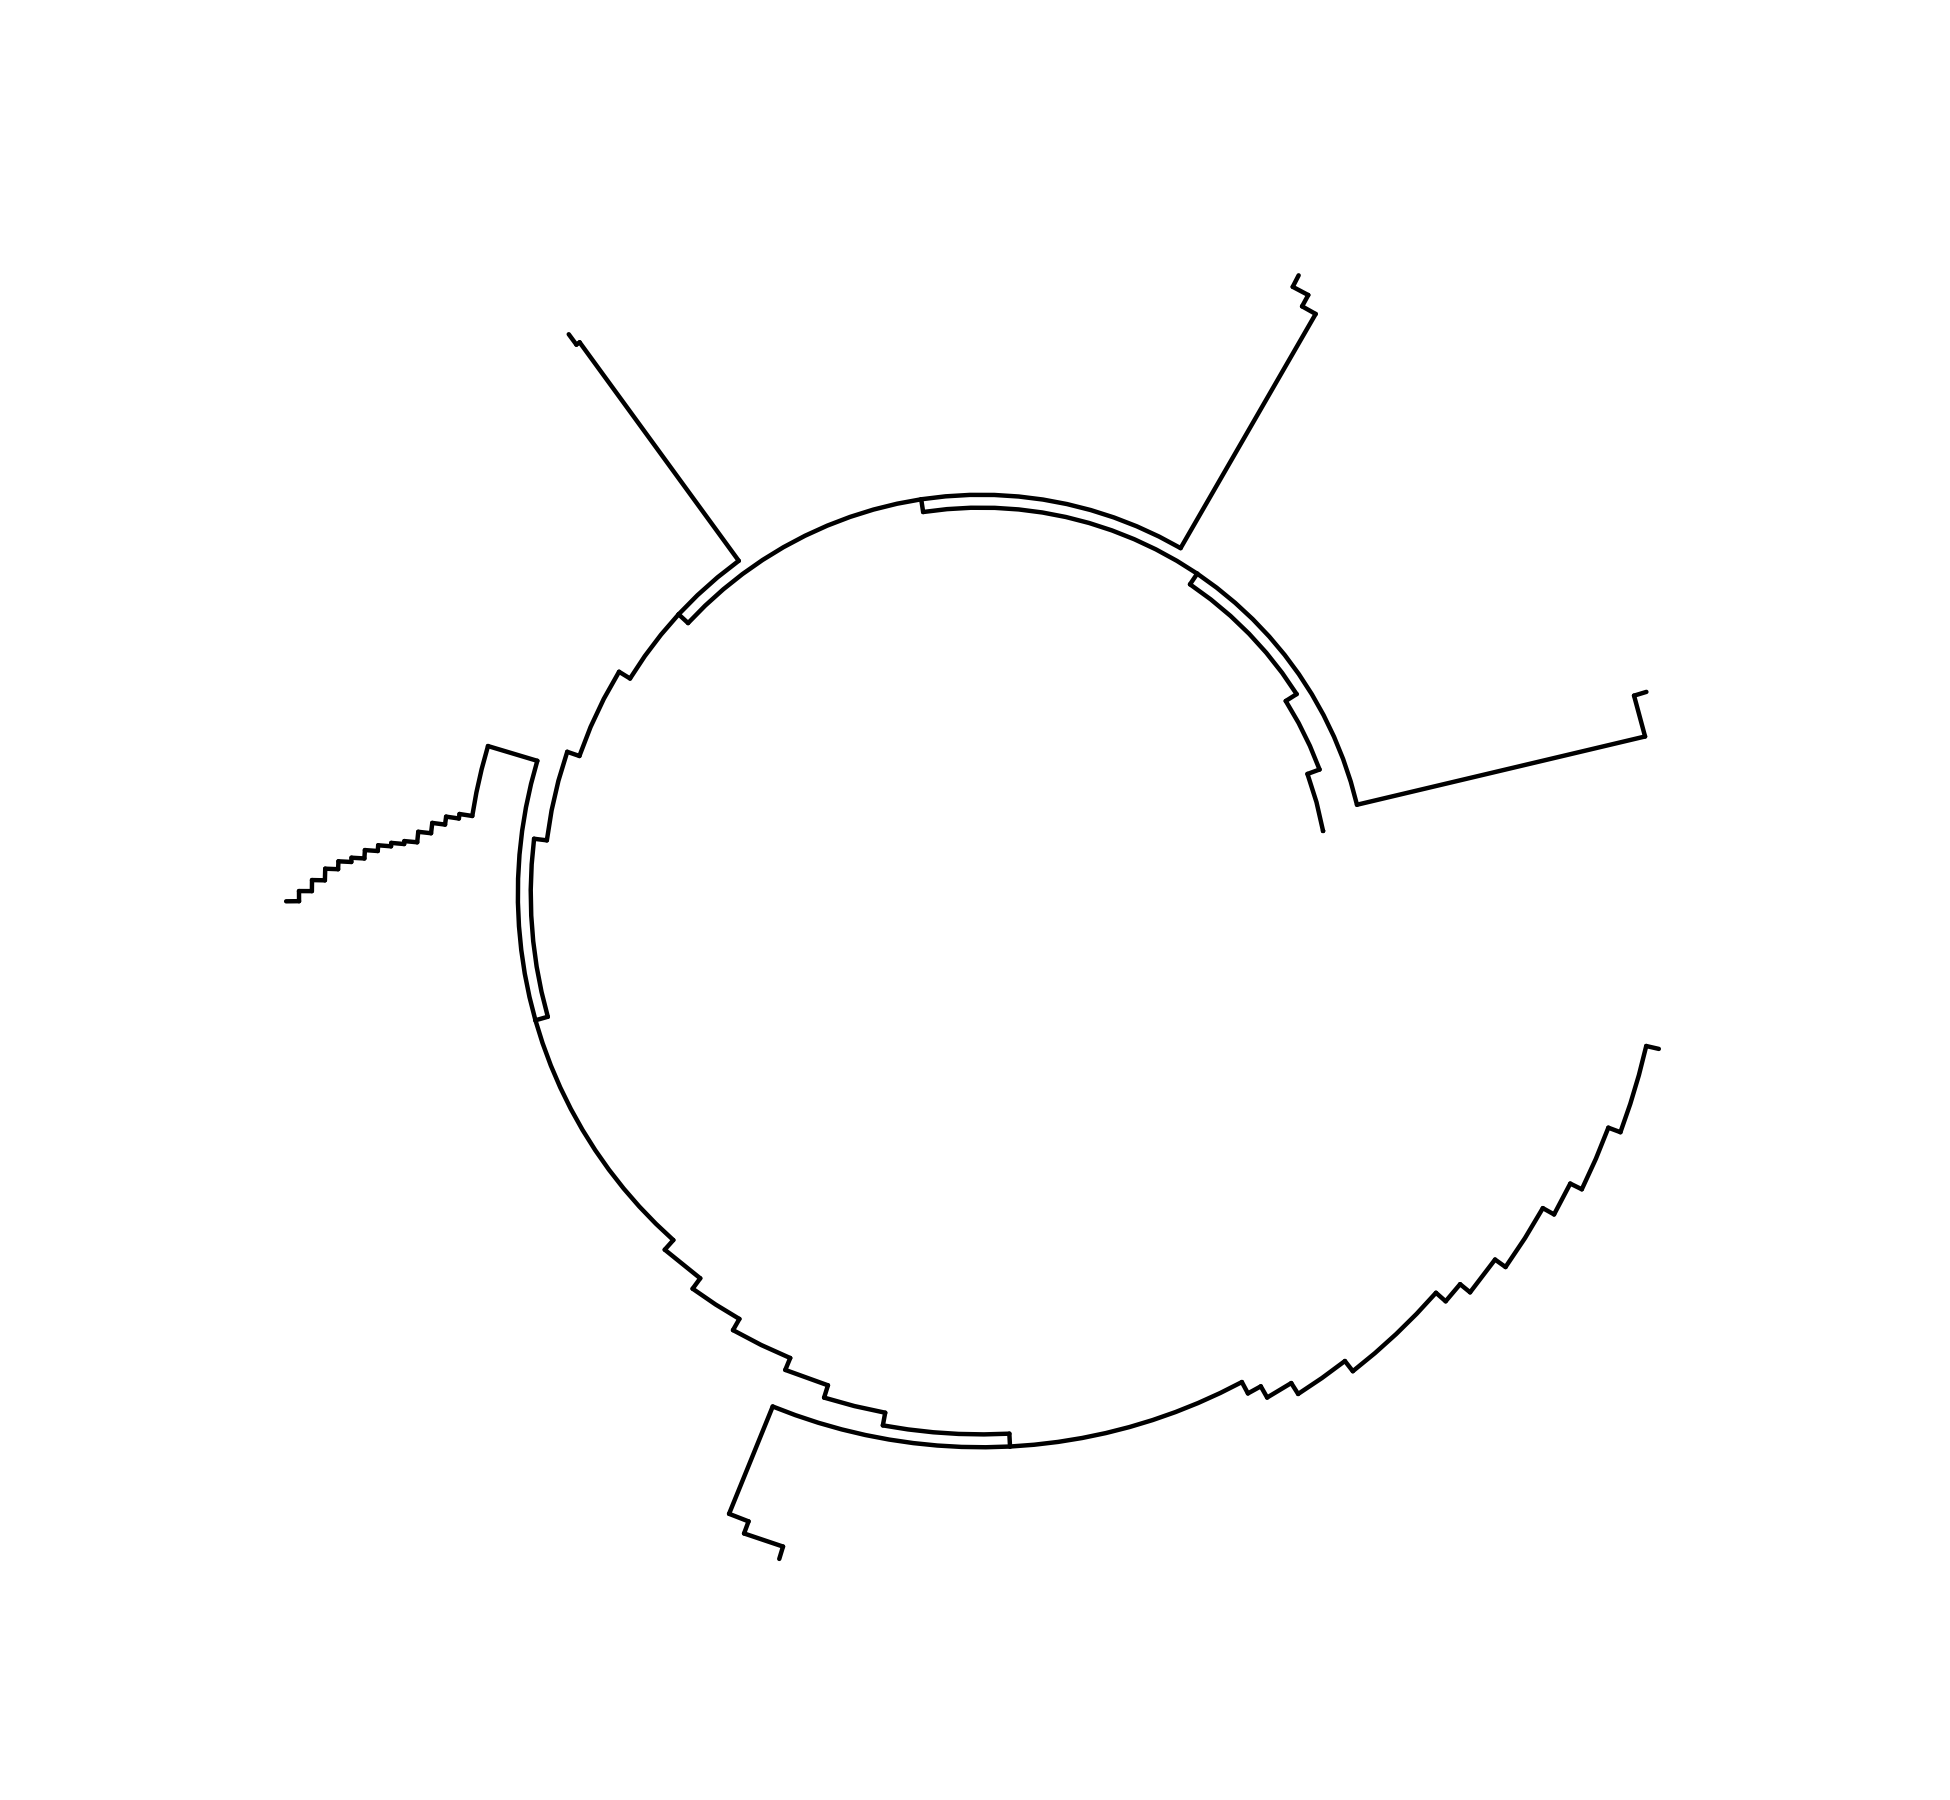

In [58]:
#pdf("figures/tree_all_shared_assemblies_labels.pdf", height = 6, width = 6.5)
# adjust plot size rendered inline
options(repr.plot.width = 6.5, repr.plot.height = 6, repr.plot.res = 300)
p_bac1 <- p_bac + 
  geom_tiplab2(aes(label = species2), fontface = 3, hjust = -.3, size = 1) +
  geom_tiplab(aes(label = rank), hjust = -0.3, size = 1) +
  geom_tippoint(aes(color=varimp_greater_than_1pct), size=0.5) +
  #geom_tippoint(aes(color = rank), size = 0.5) +
  scale_color_manual(values = c("lightgrey", "black")) +
  theme_transparent() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 8), 
        legend.text = element_text(size = 7)) +
  labs(color = "cumulative variable importance greater than 1%") +
  ggplot2::xlim(-27, 27)
p_bac1
#dev.off()

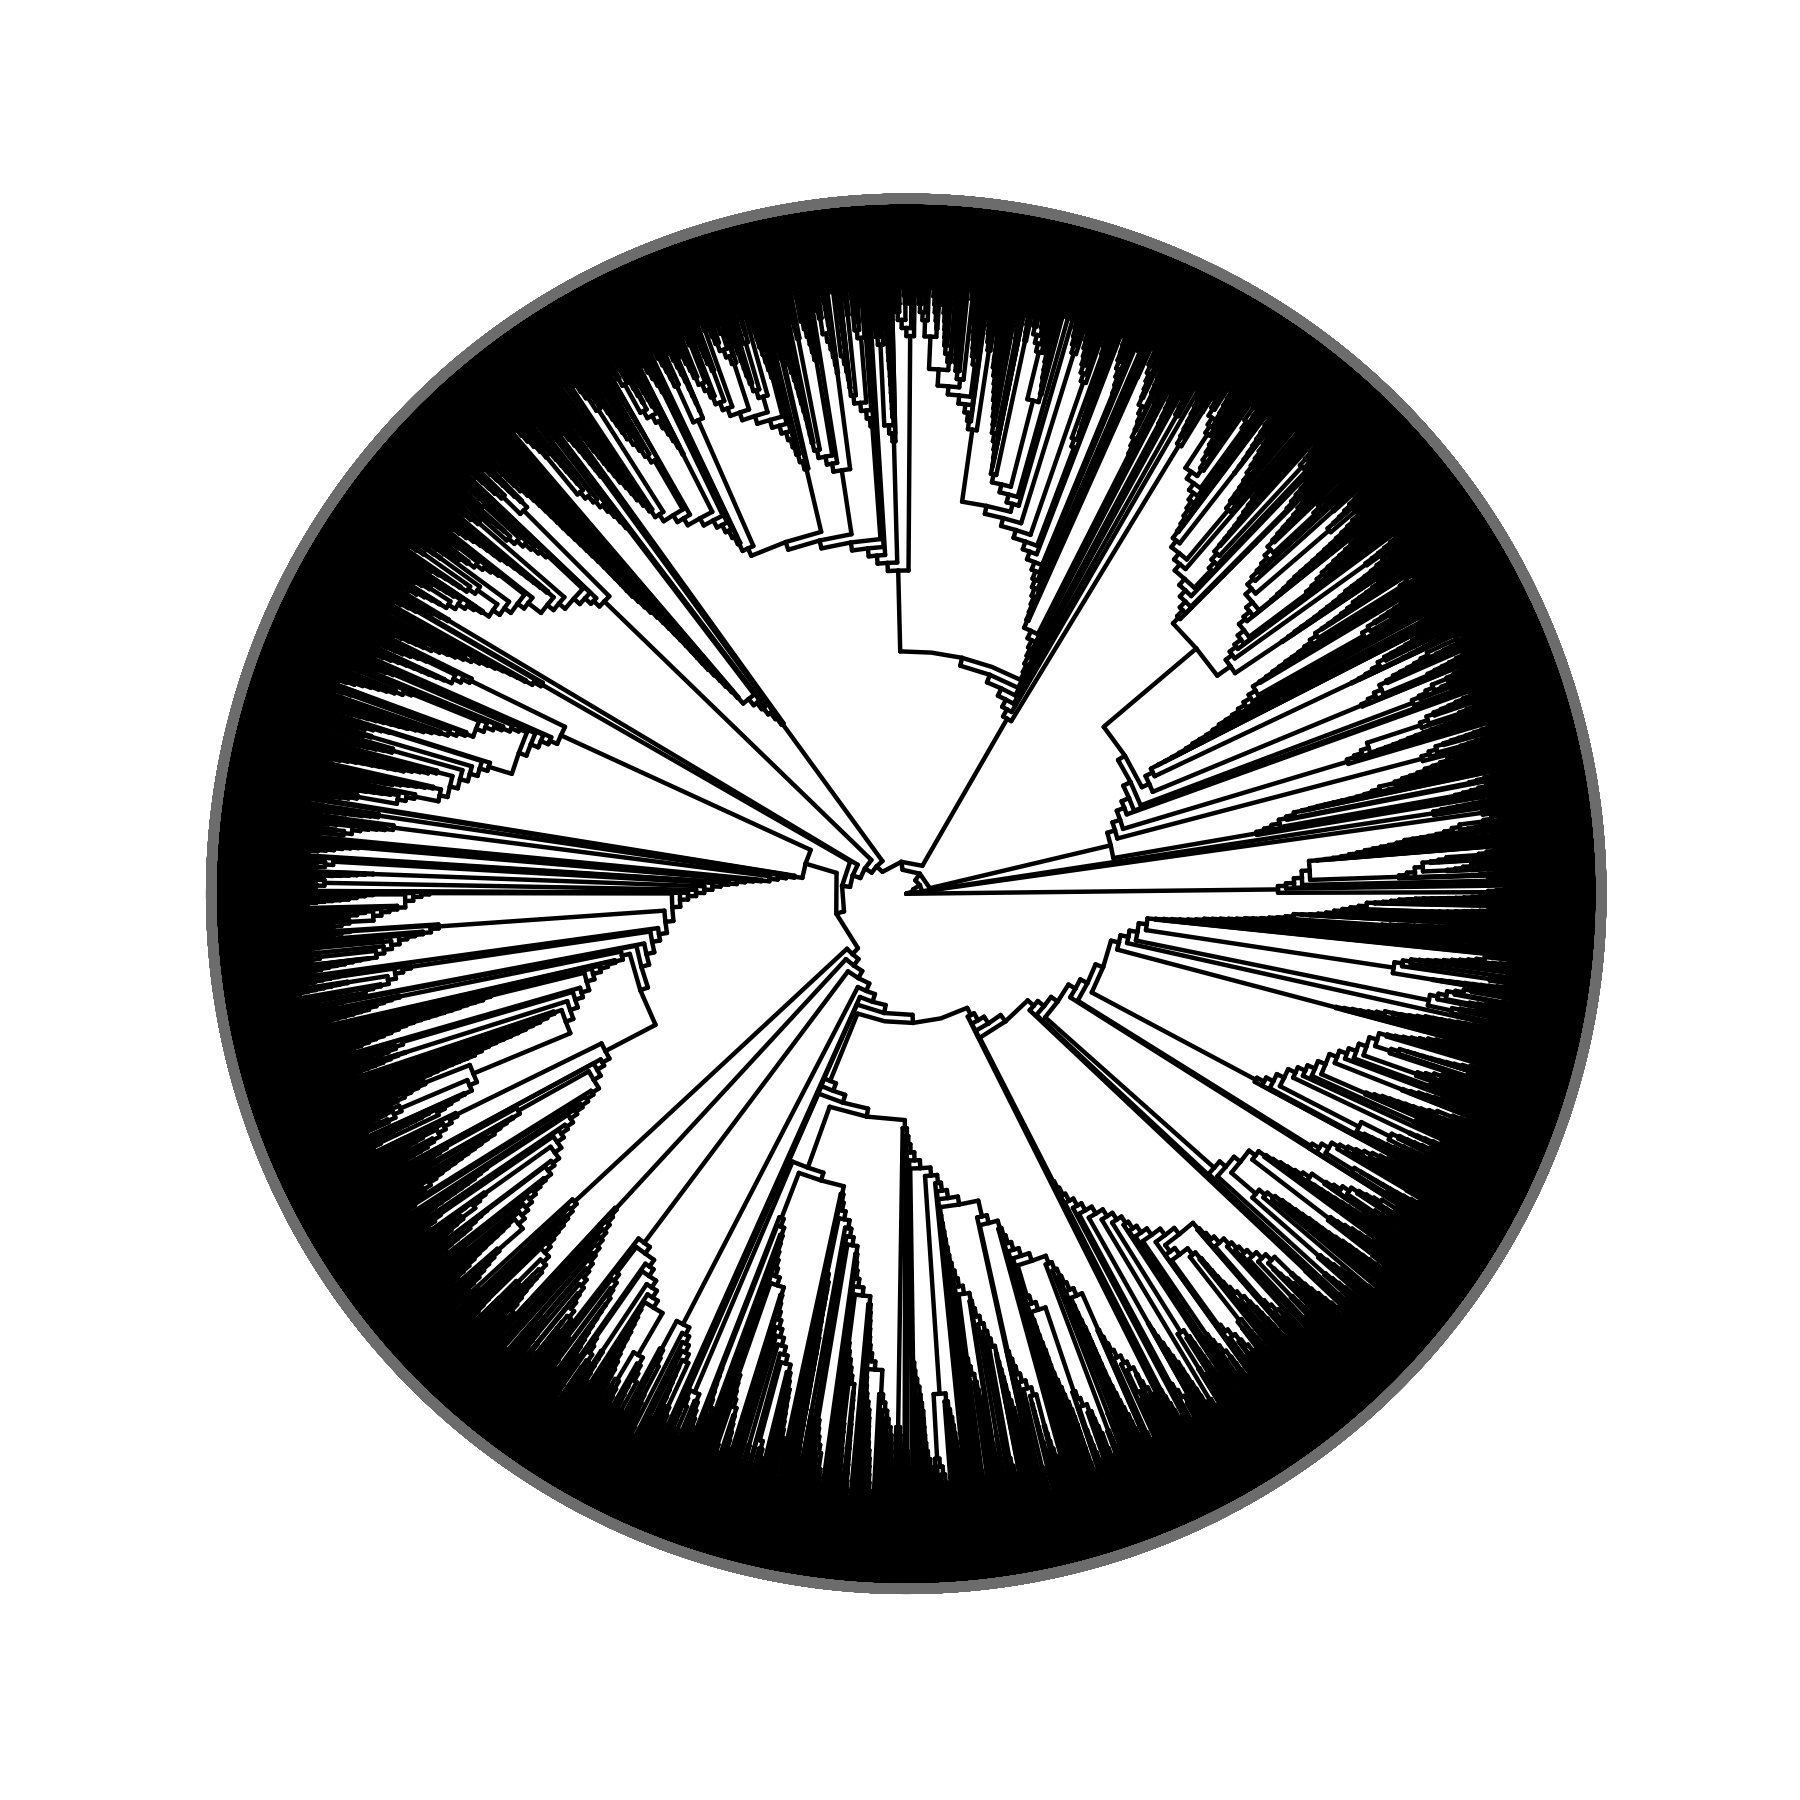

In [59]:
#pdf("figures/tree_all_shared_assemblies_no_labels.pdf", height = 6, width = 6)
# adjust plot size rendered inline
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)
p_bac2 <- p_bac + 
  geom_tippoint(aes(color=varimp_greater_than_1pct), size=0.5) +
  scale_color_manual(values = c("lightgrey", "black")) +
  theme_transparent() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 8), 
        legend.text = element_text(size = 7)) +
  labs(color = "cumulative variable importance greater than 1%")
p_bac2
#dev.off()

### summarize to taxonomic level and plot importance 

In [ ]:
# lineage_tally <- gtdb_lineages %>%
#   group_by(genus) %>%
#   tally()
# 
# lineage_sum <- gtdb_lineages %>% 
#   left_join(varimp_summarized_to_genome, by = "rank") %>%
#   group_by(genus, varimp_greater_than_1pct) %>%
#   summarize(genus_varimp = sum(all_model_norm_imp_by_genome))
# 
# ggplot(gtdb_lineages %>% 
#          left_join(varimp_summarized_to_genome, by = "rank") %>%
#          left_join(lineage_sum, by = c("genus", "varimp_greater_than_1pct")), 
#        aes(x = reorder(family, -genus_varimp), y = all_model_norm_imp_by_genome)) +
#   geom_col() +
#   theme_classic() +
#   coord_flip() +
#   facet_wrap(~varimp_greater_than_1pct, scales = "free_y") +
#   labs(y = "cumulative variable importance at rank", x = "family")
# 
# tmp <- left_join(lineage_tally, lineage_sum, by = "genus")
# ggplot(tmp, aes(x = genus, y = genus_varimp)) +
#   geom_point(aes(size = n)) +
#   theme_classic() +
#   coord_flip() 

### try other ggplot

In [35]:
library(ggforce)
library(dplyr)

In [60]:
lineage_tally <- gtdb_lineages %>%
  group_by(family) %>%
  tally()

In [61]:
lineage_sum <- gtdb_lineages %>% 
  left_join(varimp_summarized_to_genome, by = "rank") %>%
  group_by(family) %>%
  summarize(family_varimp = sum(all_model_norm_imp_by_genome))

In [62]:
tmp <- gtdb_lineages %>% 
  left_join(varimp_summarized_to_genome, by = "rank") %>%
  left_join(lineage_sum, by = "family") %>%
  select(ident, family, varimp_greater_than_1pct, varimp = all_model_norm_imp_by_genome, family_varimp)

In [63]:
tmp <- tmp %>%
  group_by(family) %>%
  mutate(varimp_frac = 2*pi*cumsum(varimp)/family_varimp,
         start = lag(varimp_frac, default = 0))

In [64]:
tmp_x <- tmp %>%
  select(family) %>%
  distinct()
tmp_x$x <- 1:nrow(tmp_x)

tmp <- left_join(tmp, tmp_x)

tmp <- tmp %>%
  arrange(family, varimp_greater_than_1pct)

Joining, by = "family"


In [65]:
# overall scaling for pie size
scale = .5/sqrt(max(tmp$family_varimp))

Warning message:
“Removed 45555 rows containing non-finite values (stat_arc_bar).”


List of 1
 $ panel.grid.minor: list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

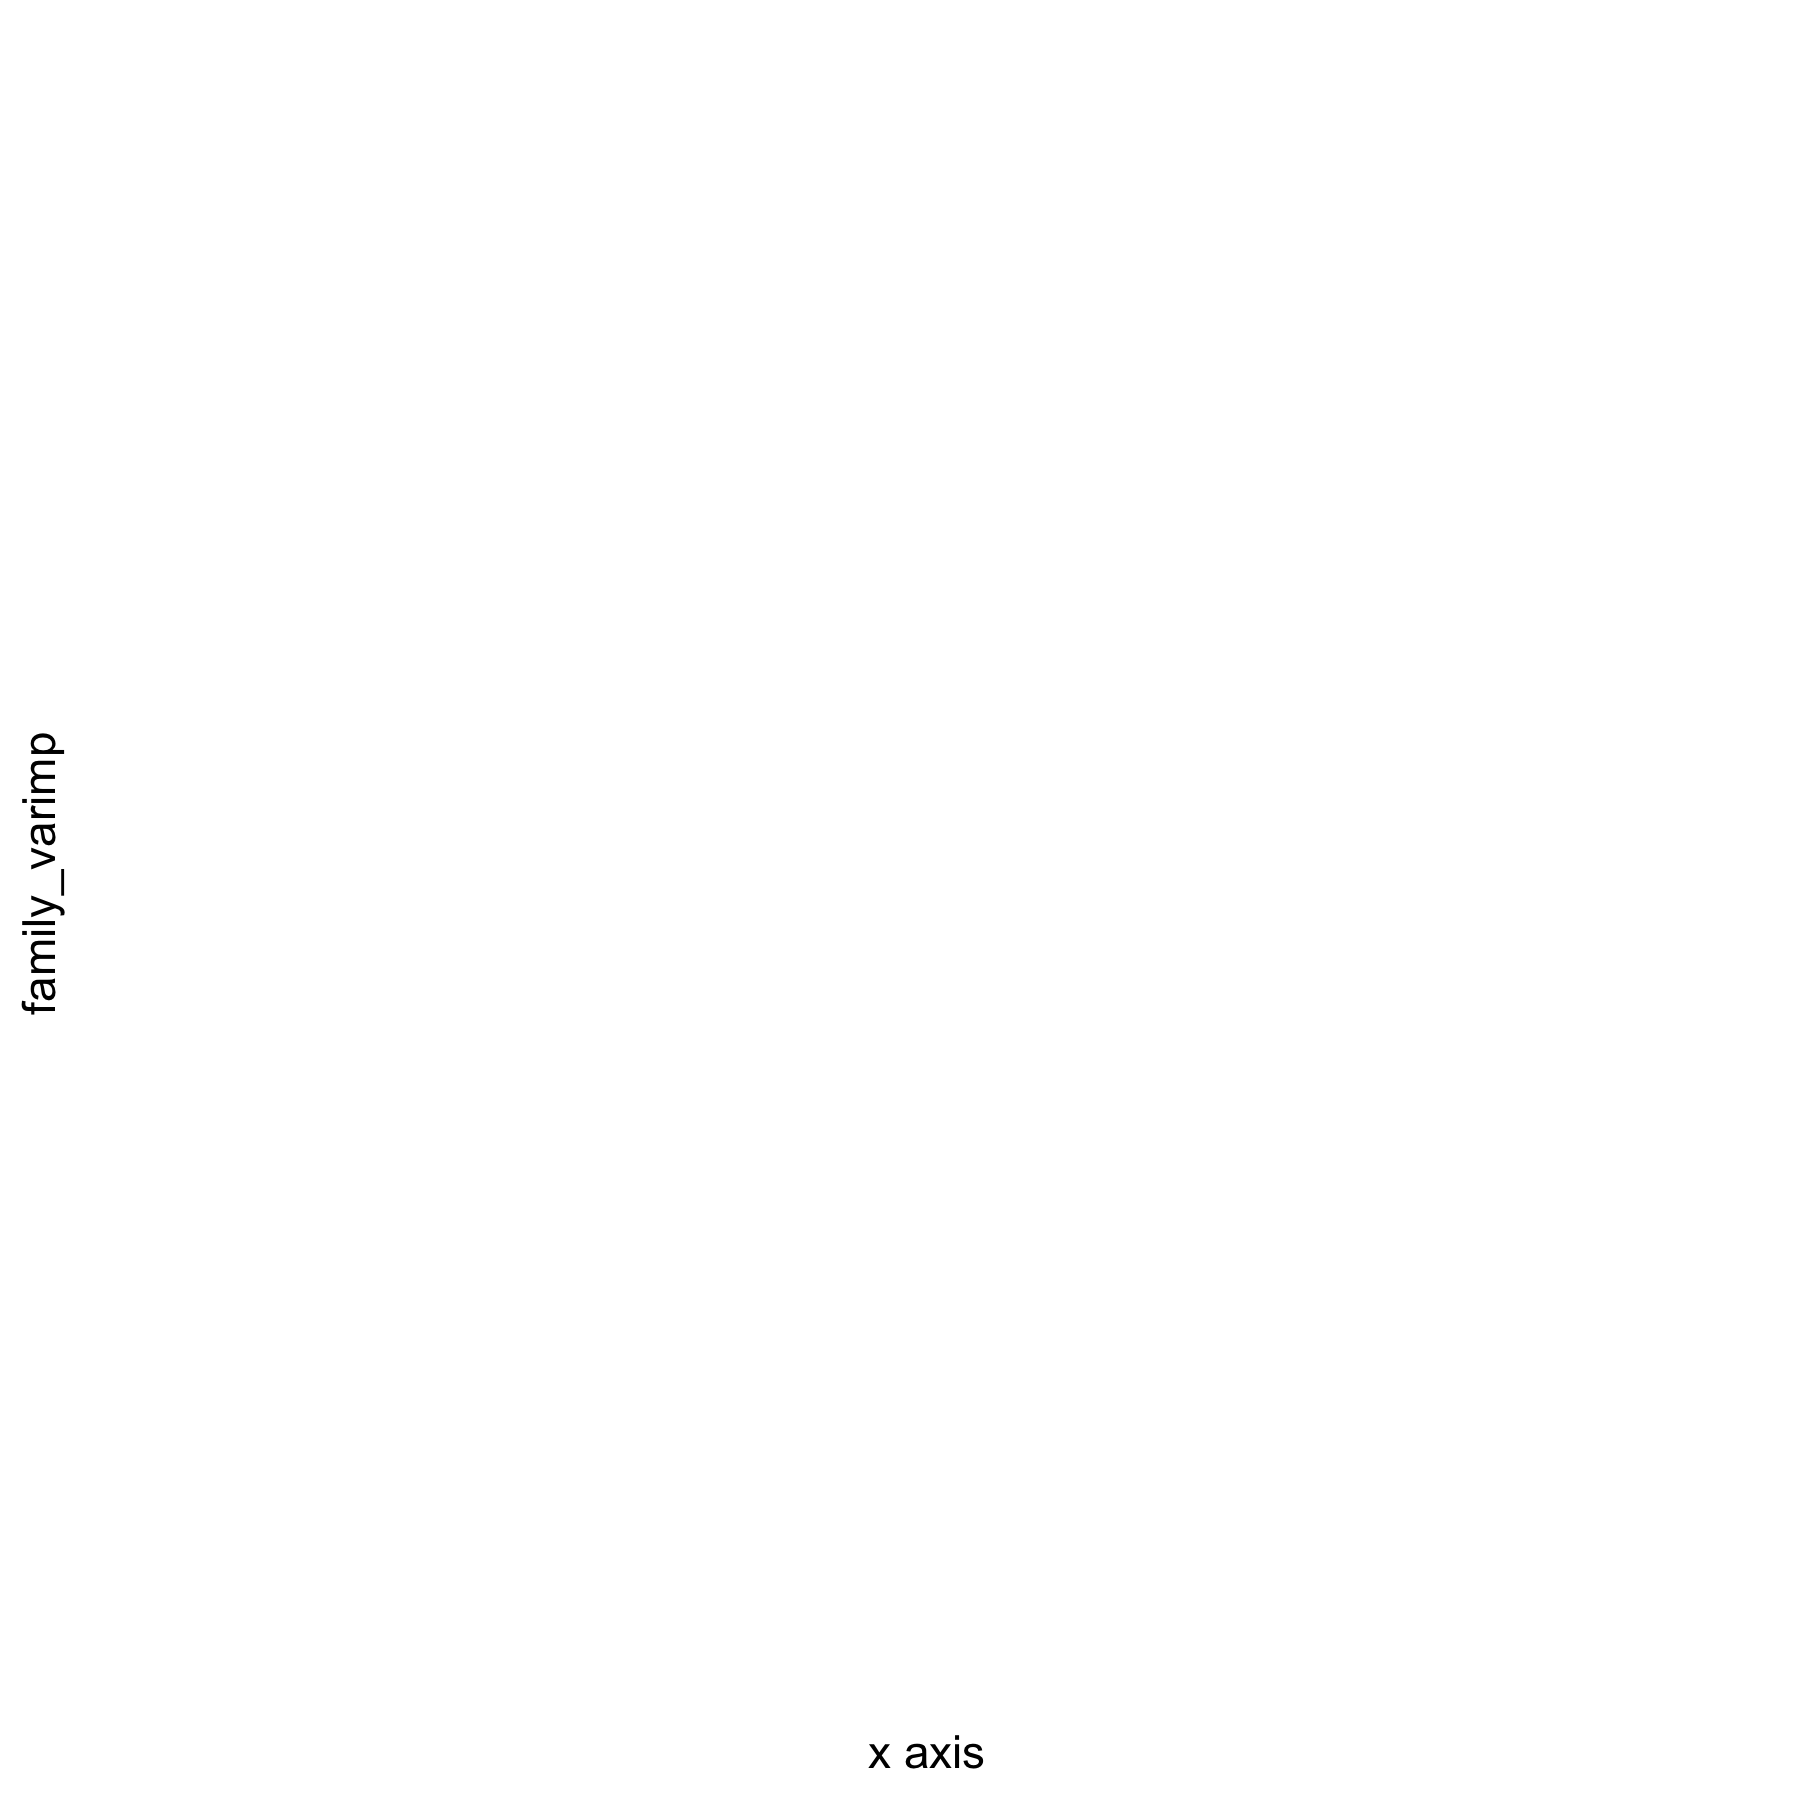

In [66]:
# draw the pies
ggplot(tmp) + 
  geom_arc_bar(aes(x0 = x, y0 = family_varimp, r0 = 0, r = sqrt(family_varimp)*scale,
                   start = start, end = varimp_frac, fill = varimp_greater_than_1pct, 
                   color = varimp_greater_than_1pct)) +
  coord_fixed() +
  scale_x_continuous(breaks = tmp_x$x, labels = tmp_x$family, name = "x axis") +
  #scale_y_continuous(breaks = c(0, 1), labels = c("Y0", "Y1"), name = "y axis") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45))
  theme(panel.grid.minor = element_blank()) 

### Try metacoder

In [67]:
gtdb_lineages <- read_csv("inputs/gtdb-rs202.taxonomy.v2.csv", show_col_types = F)
gtdb_lineages <- gtdb_lineages %>%
  filter(ident %in% genomes$accession) %>%
  left_join(genomes, by = c("ident" = "accession")) %>%
  mutate(varimp_greater_than_1pct = ifelse(rank > 54, "no", "yes"))

In [68]:
gtdb_lineages_combined <- gtdb_lineages %>%
  mutate(full_lineage = paste(sep = ";", superkingdom, phylum, class, order, family, genus, species)) %>%
  left_join(varimp_summarized_to_genome, by = "rank") %>%
  select(ident, full_lineage, varimp = all_model_norm_imp_by_genome, varimp_greater_than_1pct) %>%
  mutate(color_varimp = ifelse(varimp_greater_than_1pct == "yes", varimp, 0))

In [69]:
# figure out which genuses have species with > 1pct varimp
genus_has_species_for_sgc <- gtdb_lineages %>%
  left_join(varimp_summarized_to_genome, by = "rank") %>%
  group_by(genus, varimp_greater_than_1pct) %>%
  tally() %>%
  arrange(genus, desc(varimp_greater_than_1pct)) %>%
  ungroup() %>%
  group_by(genus) %>%
  slice_head(n = 1) %>%
  select(genus, genus_has_species_for_sgc = varimp_greater_than_1pct)

In [70]:
gtdb_lineages_combined2 <- gtdb_lineages %>%
  filter(superkingdom == "d__Bacteria") %>%
  left_join(varimp_summarized_to_genome, by = "rank") %>%
  group_by(superkingdom, phylum, class, order, family, genus) %>%
  summarize(sum_varimp = sum(all_model_norm_imp_by_genome)) %>%
  ungroup() %>%
  mutate(full_lineage = paste(sep = ";", superkingdom, phylum, class, order, family, genus)) %>%
  select(genus, varimp = sum_varimp, full_lineage) %>%
  left_join(genus_has_species_for_sgc, by = "genus") %>%
  mutate(color_varimp = ifelse(genus_has_species_for_sgc == "yes", varimp, 0))

`summarise()` has grouped output by 'superkingdom', 'phylum', 'class', 'order', 'family'. You can override using the `.groups` argument.


In [71]:
# parse gtdb info into metacoder object
obj <- parse_tax_data(gtdb_lineages_combined2,
                      class_cols = "full_lineage", # the column that contains taxonomic information
                      class_sep = ";", # The character used to separate taxa in the classification
                      class_regex = "^(.+)__(.+)$", # Regex identifying where the data for each taxon is
                      class_key = c(tax_rank = "info", # A key describing each regex capture group
                                    tax_name = "taxon_name"))

In [72]:
# set varimp at taxon level instead of just species level
obj$data$tax_abund <- calc_taxon_abund(obj, "tax_data", cols = c("varimp", "color_varimp"))

Summing per-taxon counts from 2 columns for 219 taxa



In [73]:
# heat_tree(obj, 
#           node_label = taxon_names, 
#           node_size = obj$data$tax_abund$varimp,
#           node_color = obj$data$tax_abund$color_varimp,
#           node_label_size_range = c(0.01, 0.03),
#           #node_label_size = 
#           node_color_axis_label = "color", 
#           node_size_axis_label = "size")

In [74]:
# gtdb_lineages %>% filter(varimp_greater_than_1pct == "yes") %>% select(genus) %>% distinct()

In [75]:
taxa_to_label <- c(# classes (all)
  "Gammaproteobacteria", "Actinomycetia", "Bacteroidia", 
  "Verrucomicrobiae", "Clostridia", "Bacilli", "Coriobacteriia", 
  "Negativicutes", "Clostridia_A", "Alphaproteobacteria",
  "Desulfovibrionia", "Methanobacteria",
  # orders(only >1pct)
  "Bacteroidales", "Lachnospirales", "Oscillospirales", "Peptostreptococcales",
  # family (only > 1pct)
  "Acutalibacteraceae", "Bacteroidaceae", "Lachnospiraceae", "Oscillospiraceae",
  "Peptostreptococcaceae", "Ruminococcaceae",
  # genus (only > 1pct)
  'Agathobacter', 'Bacteroides', 'Ruminococcus_B', 'Ruminococcus_E', 'Ruminococcus_D', 
  "Enterocloster", "Faecalibacterium", "Lachnospira", "RUG115", "Gemmiger",
  'Flavonifractor', 'Roseburia', 'Acetatifactor', 'CAG-81', 'ER4', 'TF01-11', 
  'Dysosmobacter', 'Phocaeicola', 'Lawsonibacter', 'Romboutsia', 'CAG-170', 
  'Anaeromassilibacillus', 'Angelakisella', 'NK3B98')
to_label <- unlist(supertaxa(obj, include_input = TRUE)[taxon_names(obj) %in% taxa_to_label])

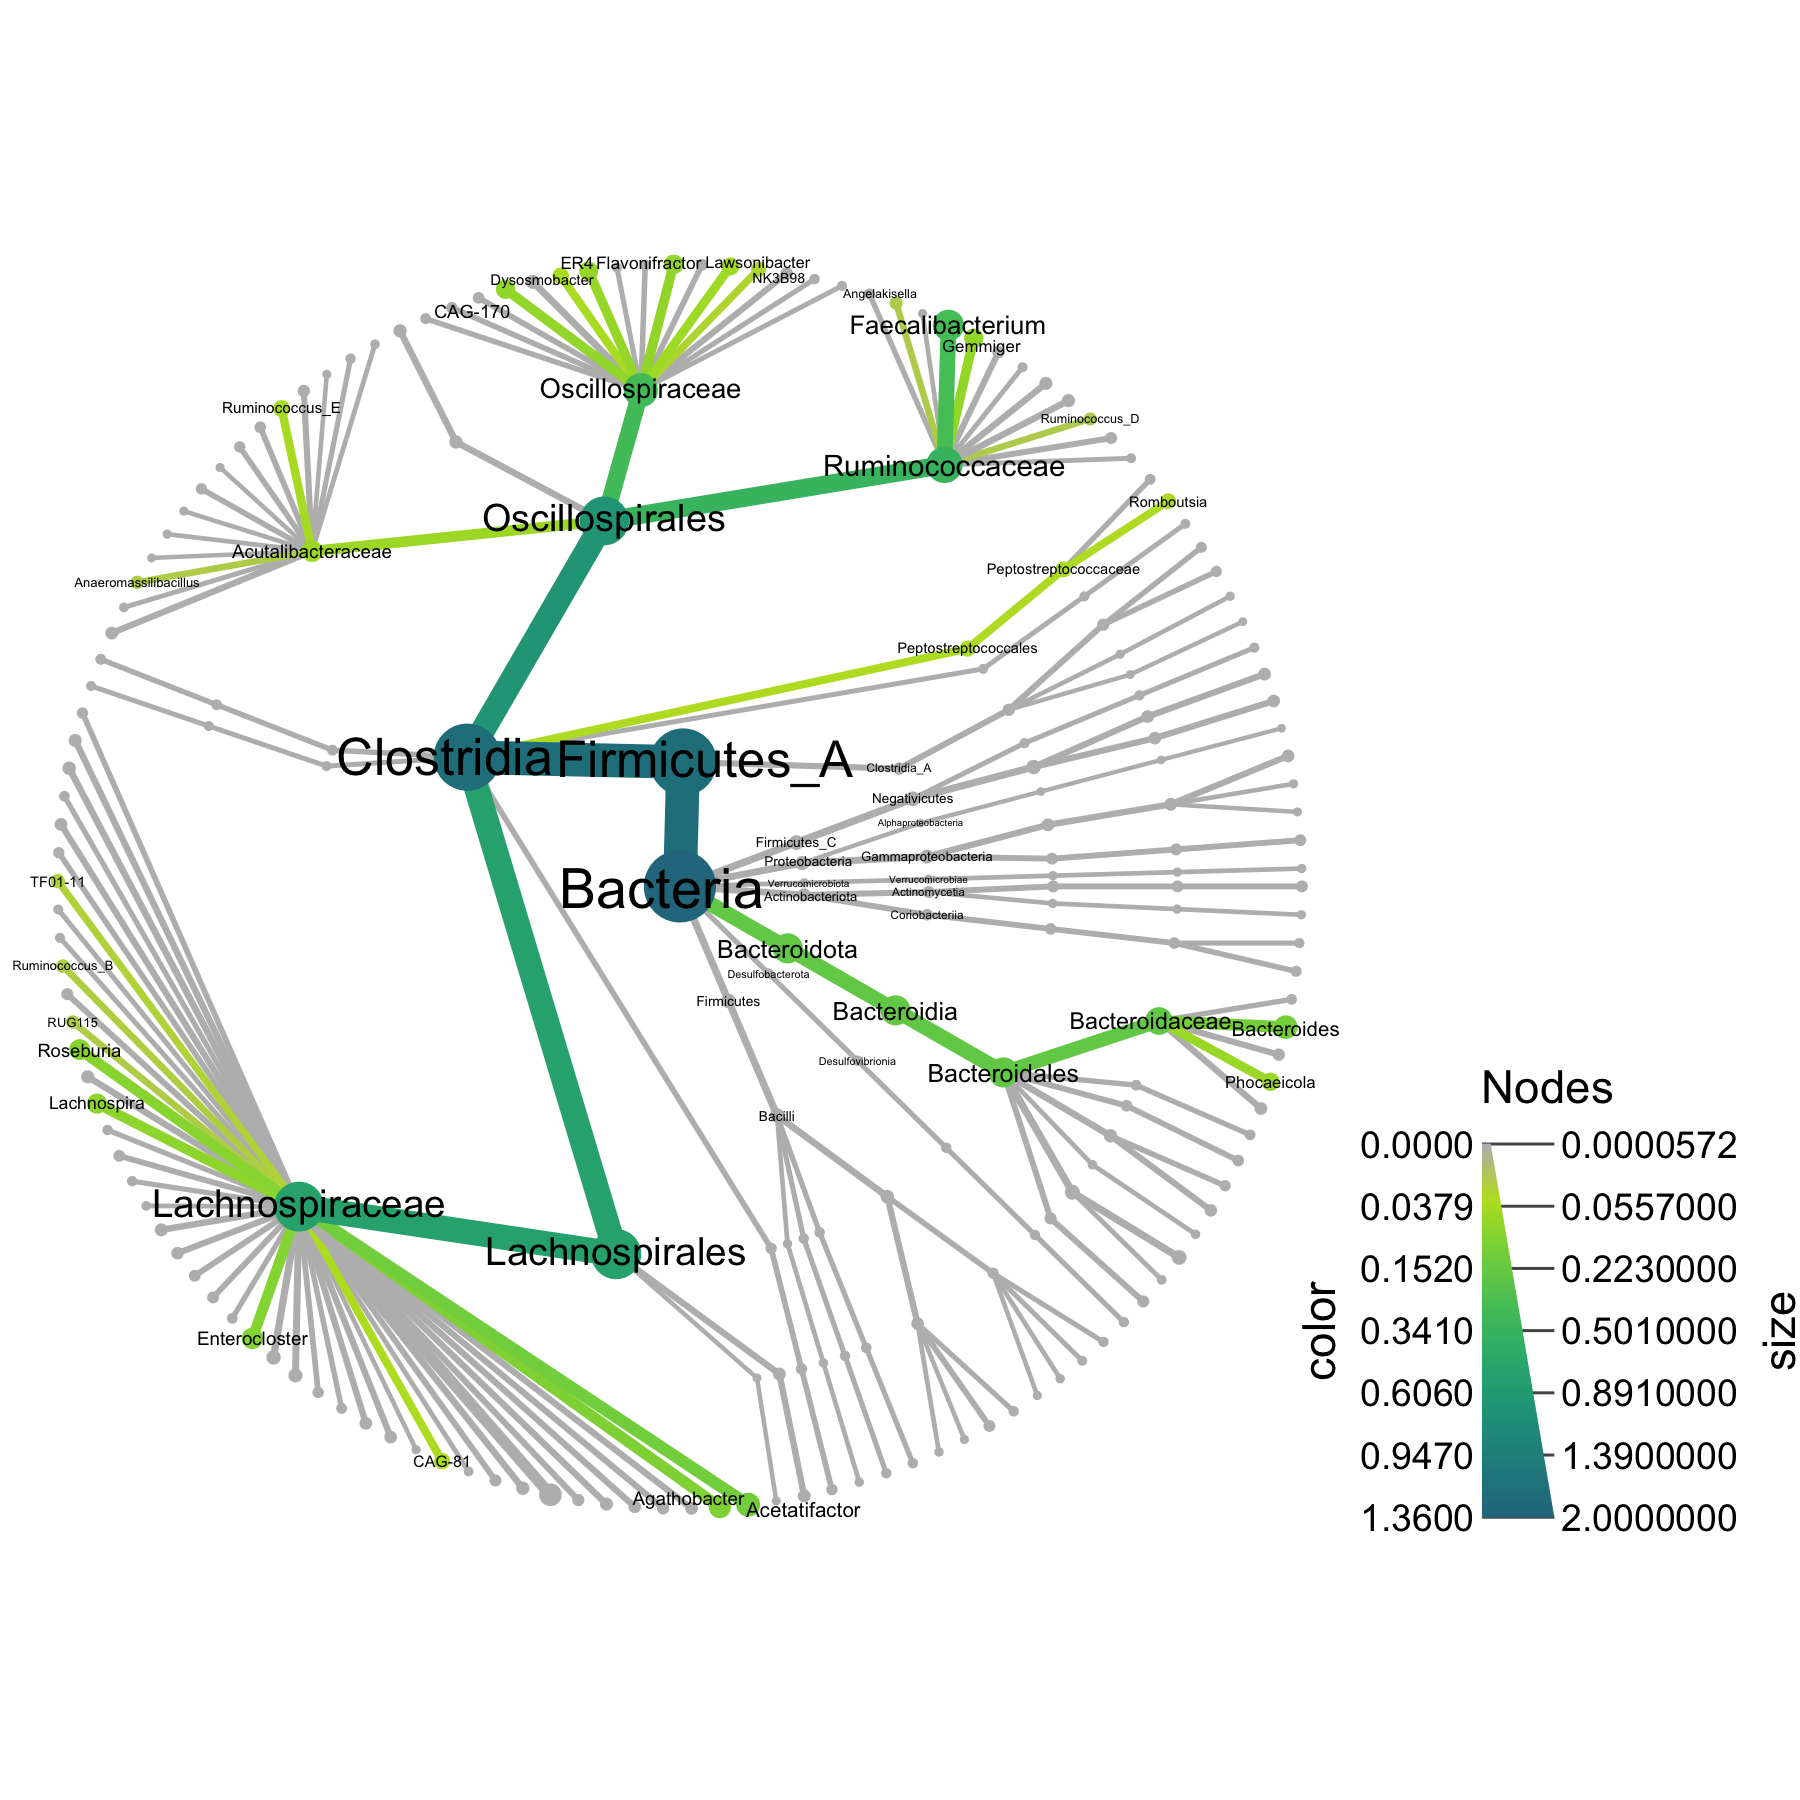

In [76]:
heat_tree(obj, 
          node_label = ifelse(taxon_indexes %in% to_label, taxon_names, ''), 
          node_size = obj$data$tax_abund$varimp,
          node_color = obj$data$tax_abund$color_varimp,
          node_label_size_range = c(0.007, 0.04),
          node_color_axis_label = "color", 
          node_size_axis_label = "size",
          output_file = "figures/metacoder_by_varimp.png")